In [1]:
import numpy as np
import pandas as pd
import re 

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import pad_sequences

from nltk.corpus import stopwords

from tensorflow.keras.layers import Input, LSTM, Bidirectional, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

import warnings

pd.set_option("display.max_colwidth", 200)

warnings.filterwarnings("ignore")

2025-05-08 17:19:55.819409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746724796.009800      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746724796.064350      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data=pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv")

In [3]:
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping null values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393560 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393560 non-null  int64 
 1   ProductId               393560 non-null  object
 2   UserId                  393560 non-null  object
 3   ProfileName             393560 non-null  object
 4   HelpfulnessNumerator    393560 non-null  int64 
 5   HelpfulnessDenominator  393560 non-null  int64 
 6   Score                   393560 non-null  int64 
 7   Time                    393560 non-null  int64 
 8   Summary                 393560 non-null  object
 9   Text                    393560 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [7]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contraction_mapping:
            tmp.append(contraction_mapping[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)
        
    return text

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in data['Summary']:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')
clean_summaries[:5]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaning Summaries Complete


['good quality dog food',
 'not as advertised',
 ' delight  says it all',
 'cough medicine',
 'great taffy']

In [9]:
clean_texts = []
for text in data['Text']:
    clean_texts.append(clean_text(text))
print('Cleaning Text Complete')
print(clean_texts[:5])
del data

Cleaning Text Complete
['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [10]:
len(clean_texts)

393560

In [11]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:1000]
clean_df['summary'] = clean_summaries[:1000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)
clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')

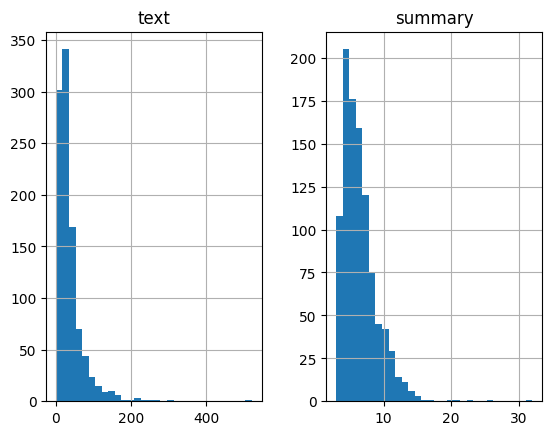

In [12]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in clean_df['text']:
      text_word_count.append(len(i.split()))

for i in clean_df['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [13]:
for i in range(5):
    print("Review:",clean_df['text'][i])
    print("Summary:",clean_df['summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: <sostok> good quality dog food <eostok>


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: <sostok> not as advertised <eostok>


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: <sostok>  delight  says it all <eostok>


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal
Summary: <sostok> cough medicine <eostok>


Review: great taffy great price wide assortment yummy taffy de

In [14]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.1, random_state=0)
del clean_df

In [15]:
text_tokens = Tokenizer()
text_tokens.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in text_tokens.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  72.40195192481474
Total Coverage of rare words:  17.211504108610217
Text Vocab:  1527


In [16]:
summary_tokens = Tokenizer()
summary_tokens.fit_on_texts(list(train_y))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in summary_tokens.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  83.56164383561644
Total Coverage of rare words:  22.17202746657029
Text Vocab:  1527


In [17]:
maxlen_text = 800
maxlen_summ = 150

In [18]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [19]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [20]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (900, 800)
Target Values Shape (900, 150)
Test Sequence (100, 800)
Target Test Shape (100, 150)


In [21]:
embeding_index = {}
embed_dim = 100
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs
t_embed = np.zeros((t_max_features, embed_dim))

for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec
s_embed = np.zeros((s_max_features, embed_dim))

for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [22]:
del embeding_index

In [23]:
from tensorflow.keras.layers import Add, Activation, Lambda, Layer
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [24]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

2025-05-08 17:21:09.379860: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 800)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 800, 100)       │        152,700 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ [(None, 800, 256),     │        234,496 │ embedding[0][0]        │
│ (Bidirectional)           │ (None, 128), (None,    │                │                        │
│                           │ 128), (None, 128),     │                │                        │
│                           │ (None, 128)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │         18,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_h (Concatenate)       │ (None, 256)            │              0 │ bidirectional[0][1],   │
│                           │                        │                │ bidirectional[0][3]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_c (Concatenate)       │ (None, 256)            │              0 │ bidirectional[0][2],   │
│                           │                        │                │ bidirectional[0][4]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 256),    │        365,568 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ enc_h[0][0],           │
│                           │ 256)]                  │                │ enc_c[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 256),    │        131,328 │ bidirectional[0][0],   │
│ (AttentionLayer)          │ (None, None, 800)]     │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_1[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 180)      │         92,340 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 994,432 (3.79 MB)

 Trainable params: 823,732 (3.14 MB)

 Non-trainable params: 170,700 (666.80 KB)

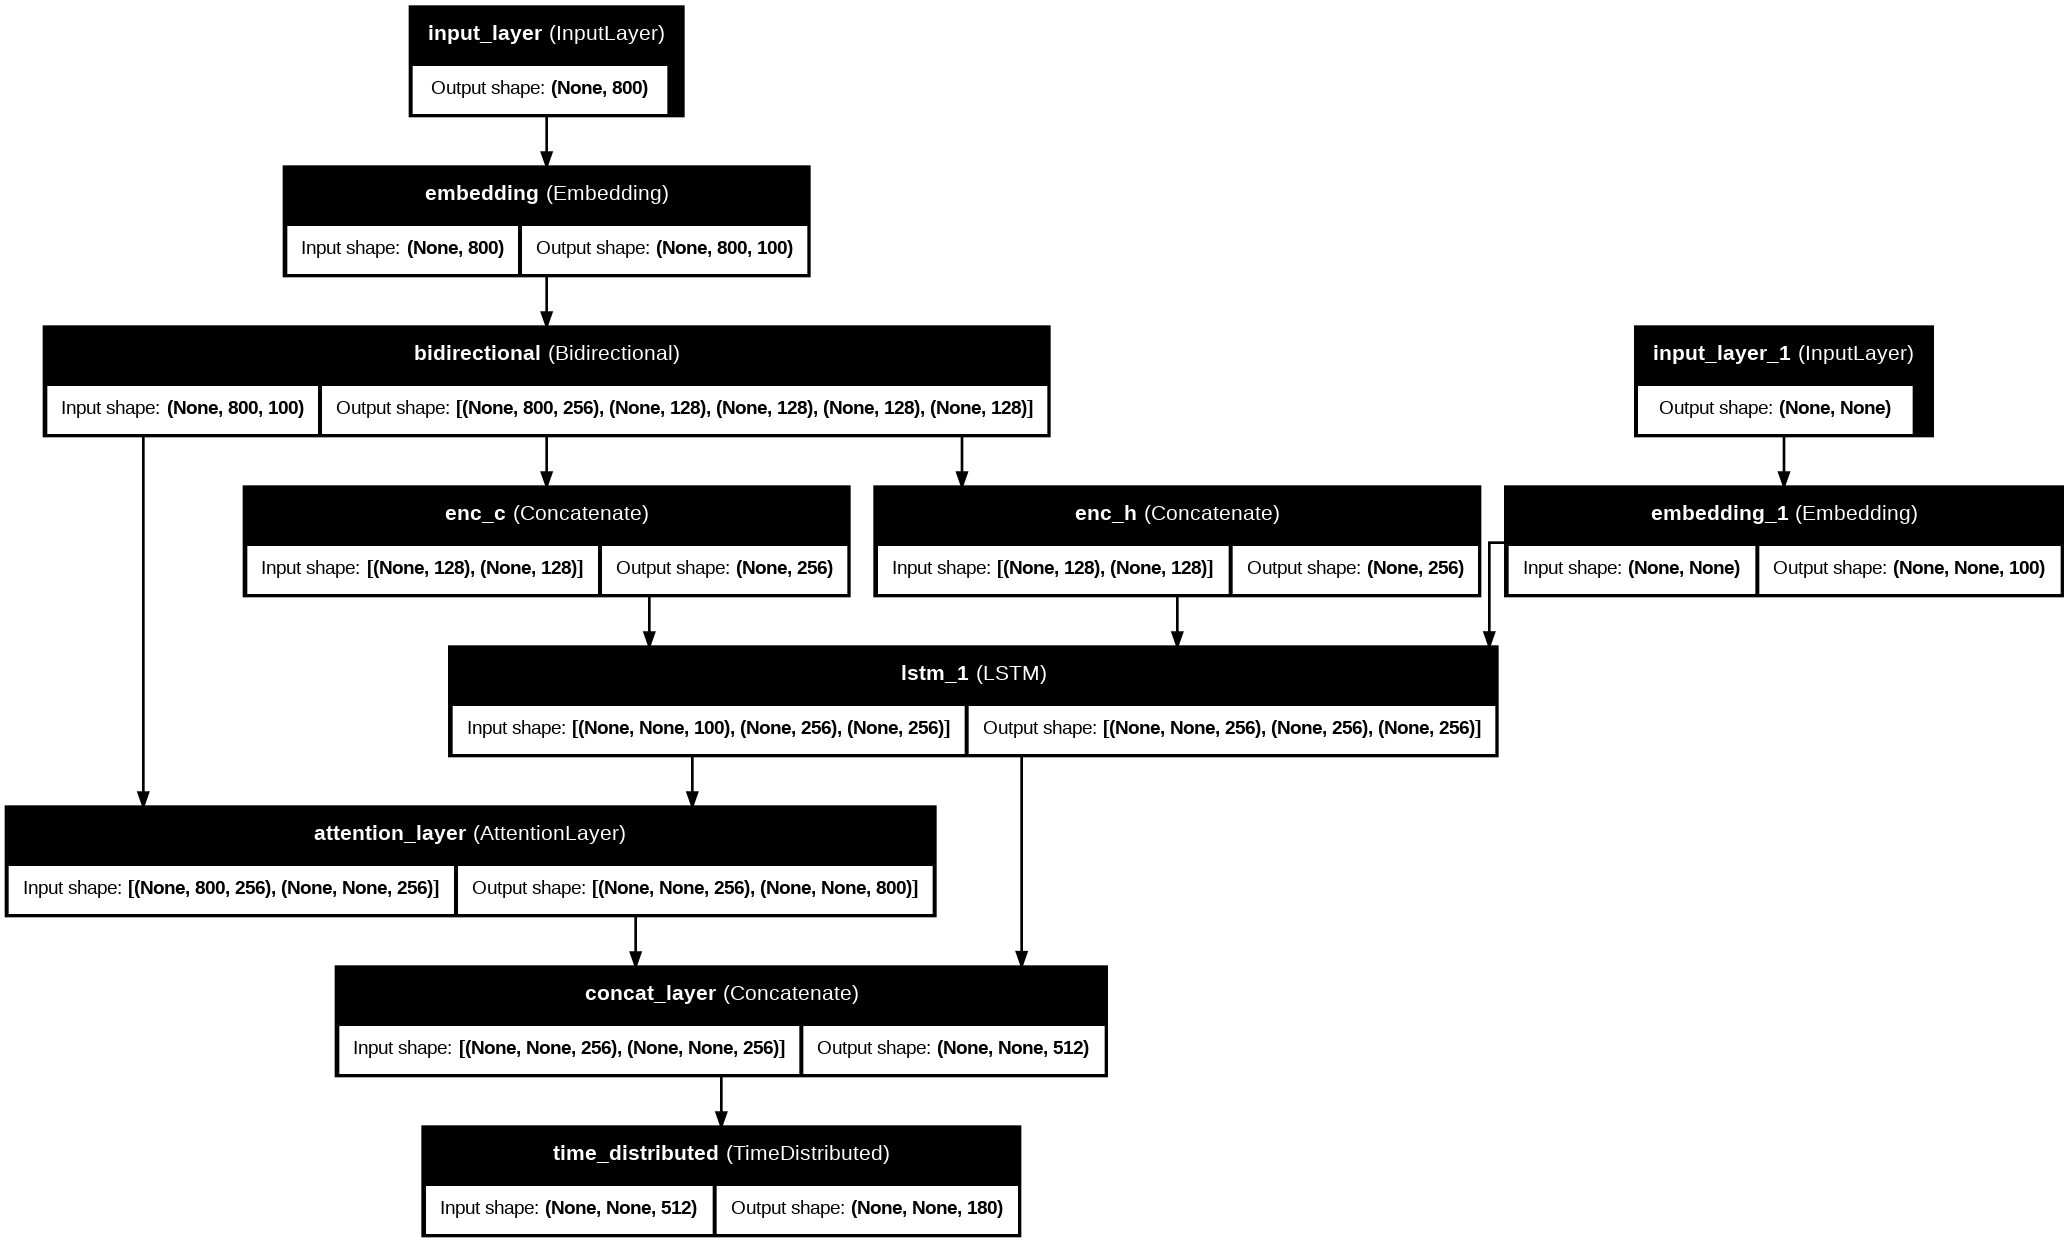

In [25]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
# h_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# h_out, _, _ = h_lstm(enc_embed)

enc_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])

#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

#Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_result = attn_layer([enc_output, dec_outputs])
attn_out = attn_result[0]
attn_states = attn_result[1]

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([dec_outputs, attn_out])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(decoder_concat_input)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [26]:
from tensorflow import keras

In [27]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='rmsprop'
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=2
)

model.fit(
    [train_x, train_y[:, :-1]], 
    train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:],
    epochs=5, callbacks=[early_stop], 
    batch_size=128, verbose=1, 
    validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 550s 66s/step - loss: 4.1069 - val_loss: 0.1573
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 532s 66s/step - loss: 0.1562 - val_loss: 0.1410
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 537s 66s/step - loss: 0.1328 - val_loss: 0.1296
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 540s 67s/step - loss: 0.1313 - val_loss: 0.1249
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 537s 66s/step - loss: 0.1252 - val_loss: 0.1212


In [29]:
# serialize model to JSON
model_json = model.to_json()
with open("summary.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("summary.weights.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
# Encoder inference model
enc_model = Model(inputs=enc_input, outputs=[enc_output, enc_h, enc_c])

# Decoder inputs for inference
dec_state_input_h = Input(shape=(latent_dim*2,))
dec_state_input_c = Input(shape=(latent_dim*2,))
enc_out_input = Input(shape=(maxlen_text, latent_dim*2))  # encoder output sequence

# Embedding input
dec_input_inf = Input(shape=(1,))  # one timestep (word) at a time
dec_embed_inf = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input_inf)

# Decoder LSTM with previous states
dec_outputs_inf, state_h_inf, state_c_inf = dec_lstm(dec_embed_inf, initial_state=[dec_state_input_h, dec_state_input_c])

# Attention
attn_result_inf = attn_layer([enc_out_input, dec_outputs_inf])
attn_out_inf = attn_result_inf[0]

# Concatenate LSTM output with attention output
decoder_inf_concat = Concatenate(axis=-1)([dec_outputs_inf, attn_out_inf])

# Final softmax output layer
dec_output_inf = dec_dense(decoder_inf_concat)

# Inference decoder model
dec_model = Model(
    inputs=[dec_input_inf, enc_out_input, dec_state_input_h, dec_state_input_c],
    outputs=[dec_output_inf, state_h_inf, state_c_inf]
)

In [32]:
import pickle

# Save encoder model
enc_model.save('./encoder_model.h5')

# Save decoder model
dec_model.save('./decoder_model.h5')

# Save tokenizer
with open('./s_tokenizer.pkl', 'wb') as f:
    pickle.dump(s_tokenizer, f)

In [33]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)
    
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''
    
    stop = False
    count = 0
    
    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])
        
        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token
        
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1
        
    return output_seq